## getting the files

In [ ]:
# import tarfile

# file = tarfile.open("102flowers.tgz")

# file.extractall('102flowers')

# file.close()

### We will be using the segmentation images => easier to train :)

In [2]:
# import tarfile

# file = tarfile.open("102segmentations.tgz")

# file.extractall('102flowersSegmentations')

# file.close()

# Run these cells

In [2]:
from scipy.io import loadmat
imagelabels = loadmat('imagelabels.mat')
print(imagelabels)

setid = loadmat('setid.mat')
print(setid)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009', '__version__': '1.0', '__globals__': [], 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}
{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009', '__version__': '1.0', '__globals__': [], 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16), 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16), 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}


In [3]:
import pandas as pd

df_labels = pd.DataFrame(imagelabels['labels'])
df_labels = df_labels.T
# rename the column such that it is image_id and labels
df_labels['image_id'] = df_labels.index +1 
# drop index by making image_id as index
df_labels.set_index('image_id', inplace=True)
# set headers to be true
df_labels.columns = ['labels']
df_labels.head()


,labels
image_id,
1,77
2,77
3,77
4,77
5,77


In [5]:
df_setid_trnid = pd.DataFrame(setid['trnid'])
df_setid_valid = pd.DataFrame(setid['valid'])
df_setid_tstid = pd.DataFrame(setid['tstid'])

df_setid_trnid = df_setid_trnid.T
df_setid_valid = df_setid_valid.T
df_setid_tstid = df_setid_tstid.T

print(df_setid_trnid.shape)
print(df_setid_valid.shape)
print(df_setid_tstid.shape)

(1020, 1)
(1020, 1)
(6149, 1)


In [6]:
import os
image_folder = '102flowersSegmentations/segmim'

image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])

df_images = pd.DataFrame(image_files, columns=['image_filename'])
df_images['image_id'] = df_images['image_filename'].str.extract(r'(\d+)').astype(int)

df_images

,image_filename,image_id
0,segmim_00001.jpg,1
1,segmim_00002.jpg,2
2,segmim_00003.jpg,3
3,segmim_00004.jpg,4
4,segmim_00005.jpg,5
...,...,...
8184,segmim_08185.jpg,8185
8185,segmim_08186.jpg,8186
8186,segmim_08187.jpg,8187
8187,segmim_08188.jpg,8188


In [7]:
df_image_labels = df_images.merge(df_labels, on='image_id', how='left')

df_image_labels

,image_filename,image_id,labels
0,segmim_00001.jpg,1,77
1,segmim_00002.jpg,2,77
2,segmim_00003.jpg,3,77
3,segmim_00004.jpg,4,77
4,segmim_00005.jpg,5,77
...,...,...,...
8184,segmim_08185.jpg,8185,62
8185,segmim_08186.jpg,8186,62
8186,segmim_08187.jpg,8187,62
8187,segmim_08188.jpg,8188,62


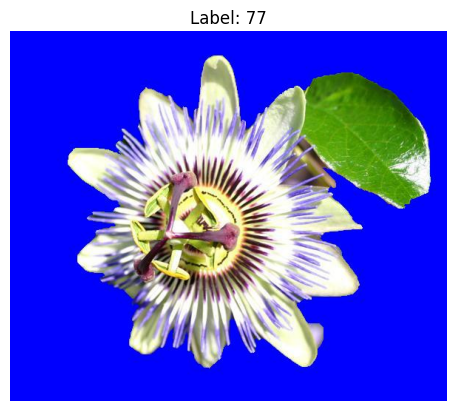

In [8]:
# error checking
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load a sample image from the merged DataFrame
sample_image_path = os.path.join(image_folder, df_image_labels['image_filename'].iloc[0])
img = mpimg.imread(sample_image_path)

# Plot the image
plt.imshow(img)
plt.title(f"Label: {df_image_labels['labels'].iloc[0]}")
plt.axis('off')
plt.show()



## train test validation split

In [9]:
# train, validation and test split
for id in df_setid_trnid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'train'

for id in df_setid_valid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'valid'

for id in df_setid_tstid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'test'

df_image_labels['set'].value_counts()


set
test     6149
valid    1020
train    1020
Name: count, dtype: int64

In [10]:
df_image_labels.to_csv('image_labels.csv', index=False)
df_image_labels.head()

,image_filename,image_id,labels,set
0,segmim_00001.jpg,1,77,test
1,segmim_00002.jpg,2,77,test
2,segmim_00003.jpg,3,77,test
3,segmim_00004.jpg,4,77,test
4,segmim_00005.jpg,5,77,test


In [11]:
num_classes = df_image_labels['labels'].nunique()
print("Number of classes: ", num_classes)

# get number of elements in each class
# for i in range(1, num_classes+1):
#     print(f"Class {i}: {df_image_labels[df_image_labels['labels'] == i].shape[0]}")

# put information in a df
df_train_distribution = df_image_labels['labels'].value_counts().reset_index()
df_train_distribution.columns = ['class', 'count']
# sort by class from 1 to 102
df_train_distribution = df_train_distribution.sort_values('count', ascending=False)


df_train_distribution




Number of classes:  102


,class,count
0,51,258
1,77,251
2,46,196
3,73,194
4,89,184
...,...,...
97,7,40
98,45,40
99,34,40
100,1,40


In [12]:
df_valid_distribution = df_image_labels[df_image_labels['set'] == 'valid']['labels'].value_counts().reset_index()   
df_valid_distribution.columns = ['class', 'count']
df_valid_distribution = df_valid_distribution.sort_values('class')
df_valid_distribution


,class,count
39,1,10
81,2,10
24,3,10
20,4,10
80,5,10
...,...,...
31,98,10
30,99,10
29,100,10
28,101,10


In [13]:
df_test_distribution = df_image_labels[df_image_labels['set'] == 'test']['labels'].value_counts().reset_index()
df_test_distribution.columns = ['class', 'count']
df_test_distribution = df_test_distribution.sort_values('class')
df_test_distribution


,class,count
100,1,20
59,2,40
95,3,20
65,4,36
52,5,45
...,...,...
36,98,62
55,99,43
77,100,29
63,101,38


In [14]:
print("Label Values: ", df_image_labels['labels'].unique())

Label Values:  [ 77  73  88  89  81  46  74  51  44  82  83  78  80  75  41  43  76  84
  58  56  86  60  92  11  65   8  23  30  72  53  37  17  12  29  52  18
  36  90  71  40  48  55  85  91  20  47  59   2   5  28  70  22  54  87
  66  32   4  42  13  38  63  68  69  93  14  64  19  49  61  50  15   9
  33  26  25   3  16  79   1  21  24  27  31  34  35  39  67  10  45   6
   7  57  62  94  95  96  97  98  99 100 101 102]


In [ ]:
# seperate folder for each class
import shutil

# Create a new directory to store the class folders (comment out this if you have already created the directory)
# os.makedirs('102flowers_segmen_split')

# Create a new directory to store the class folders (comment out this if you have already created the directory)
# os.makedirs('102flowers_segmen_split/train')
# os.makedirs('102flowers_segmen_split/valid')
# os.makedirs('102flowers_segmen_split/test')

# split based on set in the csv
for index, row in df_image_labels.iterrows():
    image_filename = row['image_filename']
    label = row['labels']
    set = row['set']
    src = os.path.join('102flowersSegmentations/segmim', image_filename)
    dst = os.path.join('102flowers_segmen_split', set, str(label))
    os.makedirs(dst, exist_ok=True)
    shutil.copy(src, dst)

    


In [17]:
# check if cuda is available
import torch
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


In [18]:
from torchvision.datasets import ImageFolder

train_folder = '102flowers_segmen_split/train'
valid_folder = '102flowers_segmen_split/valid'
test_folder = '102flowers_segmen_split/test'

train_dataset = ImageFolder(train_folder)
valid_dataset = ImageFolder(valid_folder)
test_dataset = ImageFolder(test_folder)

### Data Augmentation

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)




#### Mixup 


In [20]:
def mixup(images, labels, alpha=1.0):
    '''Apply MixUp to a batch of images and labels.'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = images.size(0)
    index = torch.randperm(batch_size)

    mixed_images = lam * images + (1 - lam) * images[index, :]
    labels_a, labels_b = labels, labels[index]

    return mixed_images, labels_a, labels_b, lam

## Data Training

### Resnet18


In [21]:
# use resnet18
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



cuda


c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
from torch.utils.data import Dataset
from PIL import Image
import os

class FlowerDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')  # Ensure it's RGB

        if self.transform:
            image = self.transform(image)  # Apply transformations to convert to tensor

        label = int(self.dataframe.iloc[idx, 1])  # Ensure labels are integers
        return image, label


In [23]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create train and validation datasets using ImageFolder
train_dataset = datasets.ImageFolder(root='102flowers_segmen_split/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder(root='102flowers_segmen_split/valid', transform=valid_transforms)

# Create dataloaders for train and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)



# Update dataloaders in a dictionary
dataloaders = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

# Update dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset)
}


In [24]:
import numpy as np
import time
from torch.optim import lr_scheduler
import copy


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss  # We use -val_loss because we want to minimize loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

    def get_best_model_weights(self):
        return self.best_model_wts





# Define the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


def train_model(model, criterion, optimizer, scheduler, num_epochs, patience):
    start = time.time()

    early_stopping = EarlyStopping(patience=patience, delta=0)

    best_model_wts = model.state_dict()
    best_acc = 0.0
    accuracy_history = {'train': [], 'valid': []}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Apply mixup in the training phase only
                if phase == 'train':
                    inputs, labels_a, labels_b, lam = mixup(inputs, labels, alpha=1.0)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # Calculate loss with mixup
                    if phase == 'train':
                        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
                    else:
                        loss = criterion(outputs, labels)  # Normal loss in validation

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update running loss
                running_loss += loss.item() * inputs.size(0)

                # Calculate correct predictions differently based on phase
                if phase == 'train':
                    running_corrects += lam * (preds == labels_a).sum().item() + (1 - lam) * (preds == labels_b).sum().item()
                else:
                    running_corrects += (preds == labels).sum().item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            accuracy_history[phase].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Early stopping check in the validation phase
            if phase == 'valid':
                early_stopping(epoch_loss, model)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    model.load_state_dict(early_stopping.get_best_model_weights())
                    return model, accuracy_history

        print()


    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, accuracy_history



In [30]:
def load_resnet18(num_frozen_layers):
    model = models.resnet18(pretrained=True)
    
    # Freeze layers
    layers_to_freeze = list(model.children())[:num_frozen_layers]
    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False
    
    # Modify the final fully connected layer for 102 classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 102)
    return model.to(device)

# Store validation accuracies for each configuration
validation_accuracies = {}

# Parameters for training
num_epochs = 20
learning_rate = 0.001

# Loop over different numbers of frozen layers
for num_frozen_layers in range(0, 4):  # From 0 to 3 layers frozen
    print(f"\nTraining with {num_frozen_layers} frozen layers...")
    
    # Load model with the specified number of frozen layers
    model = load_resnet18(num_frozen_layers)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    
    # Define the learning rate scheduler
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the model
    model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs, patience=5)
    # Get the best validation accuracy for this configuration
    best_valid_acc = max(accuracy_history['valid'])
    validation_accuracies[num_frozen_layers] = best_valid_acc

    print(f"Best validation accuracy with {num_frozen_layers} frozen layers: {best_valid_acc:.4f}")

# Find the configuration with the best validation accuracy
best_num_frozen_layers = max(validation_accuracies, key=validation_accuracies.get)
best_accuracy = validation_accuracies[best_num_frozen_layers]

print(f"\nBest configuration: {best_num_frozen_layers} frozen layers")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")


Training with 0 frozen layers...
Epoch 0/19
----------
train Loss: 4.3791 Acc: 0.0959
valid Loss: 3.5302 Acc: 0.2029

Epoch 1/19
----------
train Loss: 3.4731 Acc: 0.2535
valid Loss: 3.2731 Acc: 0.2186

Epoch 2/19
----------
train Loss: 3.3067 Acc: 0.2787
valid Loss: 2.7129 Acc: 0.3402

Epoch 3/19
----------
train Loss: 2.7806 Acc: 0.4081
valid Loss: 2.2963 Acc: 0.4422

Epoch 4/19
----------
train Loss: 2.6538 Acc: 0.4402
valid Loss: 2.1241 Acc: 0.5010

Epoch 5/19
----------
train Loss: 2.5862 Acc: 0.4750
valid Loss: 2.3747 Acc: 0.4176

Epoch 6/19
----------
train Loss: 2.3248 Acc: 0.5317
valid Loss: 2.0090 Acc: 0.5020

Epoch 7/19
----------
train Loss: 2.3245 Acc: 0.5484
valid Loss: 1.4345 Acc: 0.6539

Epoch 8/19
----------
train Loss: 1.9630 Acc: 0.6668
valid Loss: 1.4071 Acc: 0.6608

Epoch 9/19
----------
train Loss: 1.6786 Acc: 0.7213
valid Loss: 1.3533 Acc: 0.6853

Epoch 10/19
----------
train Loss: 1.9470 Acc: 0.6516
valid Loss: 1.3428 Acc: 0.6873

Epoch 11/19
----------
train L

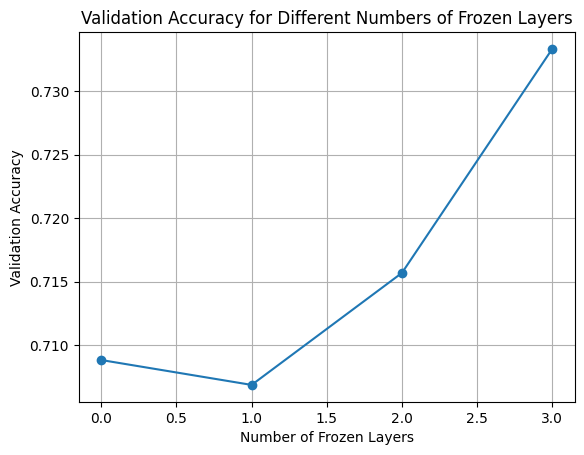

In [31]:
# plot the accuracies
plt.plot(list(validation_accuracies.keys()), list(validation_accuracies.values()), marker='o')
plt.xlabel('Number of Frozen Layers')
plt.ylabel('Validation Accuracy')

plt.title('Validation Accuracy for Different Numbers of Frozen Layers')
plt.grid(True)
plt.show()


Resnet18 is a widely used CNN known for its residual connections
- residual connections help prevent problem of vanishing gradients
- other info in vgg16 explanation, very similar reasoning for the freezing and modification of final layer





In [52]:
# save the model with 3 frozen layers
model = load_resnet18(3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20, patience=5)

torch.save(model.state_dict(), 'model_restnet18(3).pth')

c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/19
----------
train Loss: 4.5032 Acc: 0.0900
valid Loss: 7.0062 Acc: 0.0765

Epoch 1/19
----------
train Loss: 3.6138 Acc: 0.1992
valid Loss: 2.9382 Acc: 0.2686

Epoch 2/19
----------
train Loss: 3.0334 Acc: 0.3368
valid Loss: 2.5995 Acc: 0.3412

Epoch 3/19
----------
train Loss: 2.7508 Acc: 0.4201
valid Loss: 2.3898 Acc: 0.4088

Epoch 4/19
----------
train Loss: 2.6863 Acc: 0.4574
valid Loss: 2.9406 Acc: 0.3461

Epoch 5/19
----------
train Loss: 2.6082 Acc: 0.4488
valid Loss: 2.7997 Acc: 0.3461

Epoch 6/19
----------
train Loss: 2.3363 Acc: 0.5293
valid Loss: 1.8754 Acc: 0.5559

Epoch 7/19
----------
train Loss: 2.0233 Acc: 0.6248
valid Loss: 2.0082 Acc: 0.4735

Epoch 8/19
----------
train Loss: 2.1888 Acc: 0.5713
valid Loss: 1.9596 Acc: 0.5098

Epoch 9/19
----------
train Loss: 2.0519 Acc: 0.5973
valid Loss: 2.1088 Acc: 0.4863

Epoch 10/19
----------
train Loss: 2.1905 Acc: 0.5606
valid Loss: 1.9762 Acc: 0.5324

Epoch 11/19
----------
train Loss: 2.0322 Acc: 0.6031
valid Loss

### VGG

#### VGG16

In [32]:
from torchvision import models
import torch.nn as nn

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Modify the classifier to have 102 output classes
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 102)  # Replace final layer with 102 output classes

# Move the model to the device (GPU or CPU)
vgg16 = vgg16.to(device)


c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)  # Adjust learning rate as needed

# Define a learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [38]:
import torch.nn as nn
from torchvision import models

dataloaders = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

def load_vgg16(num_frozen_layers):
    vgg16 = models.vgg16(pretrained=True)
    
    # Freeze layers
    layers_to_freeze = list(vgg16.features.children())[:num_frozen_layers]
    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False
    
    # Modify the final fully connected layer for 102 classes
    num_features = vgg16.classifier[6].in_features
    vgg16.classifier[6] = nn.Linear(num_features, 102)
    return vgg16.to(device)

# Load VGG16 with specified number of frozen layers
num_frozen_layers =  10
model = load_vgg16(num_frozen_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Define the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 30

# Train the model with mixup and early stopping
model, accuracy_history = train_model(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=exp_lr_scheduler, 
    num_epochs=num_epochs, 
    patience=5  # Set early stopping patience
)


c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 4.6834 Acc: 0.0118
valid Loss: 4.5356 Acc: 0.0422

Epoch 1/29
----------
train Loss: 4.5402 Acc: 0.0341
valid Loss: 4.3055 Acc: 0.1176

Epoch 2/29
----------
train Loss: 4.1743 Acc: 0.0926
valid Loss: 3.2826 Acc: 0.3108

Epoch 3/29
----------
train Loss: 3.7809 Acc: 0.1843
valid Loss: 2.8117 Acc: 0.3461

Epoch 4/29
----------
train Loss: 3.1706 Acc: 0.3014
valid Loss: 2.0178 Acc: 0.5167

Epoch 5/29
----------
train Loss: 2.9987 Acc: 0.3486
valid Loss: 1.8556 Acc: 0.5824

Epoch 6/29
----------
train Loss: 2.7473 Acc: 0.4132
valid Loss: 1.7675 Acc: 0.5941

Epoch 7/29
----------
train Loss: 2.6409 Acc: 0.4678
valid Loss: 1.4432 Acc: 0.6500

Epoch 8/29
----------
train Loss: 2.5763 Acc: 0.4868
valid Loss: 1.4359 Acc: 0.6559

Epoch 9/29
----------
train Loss: 2.3357 Acc: 0.5311
valid Loss: 1.3383 Acc: 0.6735

Epoch 10/29
----------
train Loss: 2.2644 Acc: 0.5484
valid Loss: 1.3303 Acc: 0.6735

Epoch 11/29
----------
train Loss: 2.3219 Acc: 0.5441
valid Loss

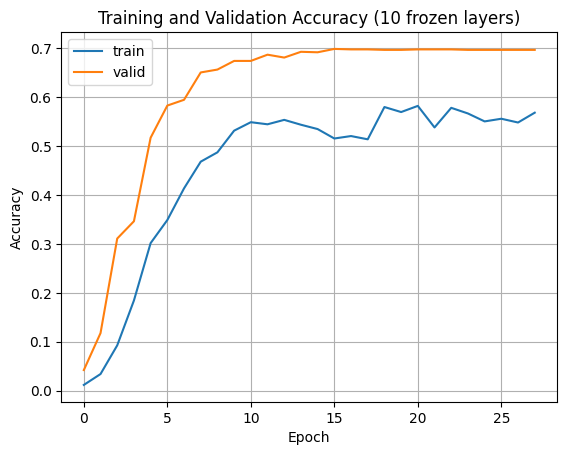

In [39]:
# Plot the training and validation accuracies
plt.plot(accuracy_history['train'], label='train')
plt.plot(accuracy_history['valid'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (10 frozen layers)')
plt.grid(True)
plt.show()


In [45]:
for num_frozen_layers in range(7,15):
    print(f"\nTraining with {num_frozen_layers} frozen layers...")
    
    # Load model with the specified number of frozen layers
    model = load_vgg16(num_frozen_layers)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)
    
    # Define the learning rate scheduler
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the model
    model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30, patience=5)
    # Get the best validation accuracy for this configuration
    best_valid_acc = max(accuracy_history['valid'])
    validation_accuracies[num_frozen_layers] = best_valid_acc

    print(f"Best validation accuracy with {num_frozen_layers} frozen layers: {best_valid_acc:.4f}")



Training with 7 frozen layers...


c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 4.6807 Acc: 0.0127
valid Loss: 4.5619 Acc: 0.0373

Epoch 1/29
----------
train Loss: 4.5561 Acc: 0.0321
valid Loss: 4.3791 Acc: 0.0912

Epoch 2/29
----------
train Loss: 4.3103 Acc: 0.0697
valid Loss: 3.6133 Acc: 0.2108

Epoch 3/29
----------
train Loss: 3.8088 Acc: 0.1521
valid Loss: 2.7092 Acc: 0.3804

Epoch 4/29
----------
train Loss: 3.0803 Acc: 0.3219
valid Loss: 2.0546 Acc: 0.5069

Epoch 5/29
----------
train Loss: 2.8363 Acc: 0.3671
valid Loss: 1.8293 Acc: 0.5618

Epoch 6/29
----------
train Loss: 2.9403 Acc: 0.3782
valid Loss: 1.6105 Acc: 0.6167

Epoch 7/29
----------
train Loss: 2.4167 Acc: 0.5100
valid Loss: 1.4527 Acc: 0.6471

Epoch 8/29
----------
train Loss: 2.3027 Acc: 0.5470
valid Loss: 1.3937 Acc: 0.6569

Epoch 9/29
----------
train Loss: 2.3697 Acc: 0.5385
valid Loss: 1.4130 Acc: 0.6716

Epoch 10/29
----------
train Loss: 2.3905 Acc: 0.5303
valid Loss: 1.3537 Acc: 0.6824

Epoch 11/29
----------
train Loss: 2.3380 Acc: 0.5223
valid Loss

In [49]:


# split 0 to 3 to resnet18 and 7 to 15 to vgg16
resnet_validation_accuracies = {k: v for k, v in validation_accuracies.items() if k in range(0, 4)}
vgg16_validation_accuracies = {k: v for k, v in validation_accuracies.items() if k in range(7, 15)}

{0: 0.7088235294117647, 1: 0.7068627450980393, 2: 0.7156862745098039, 3: 0.7333333333333333, 7: 0.6990196078431372, 8: 0.7049019607843138, 9: 0.6901960784313725, 10: 0.6774509803921569, 11: 0.6686274509803921, 12: 0.6882352941176471, 13: 0.6941176470588235, 14: 0.6852941176470588}


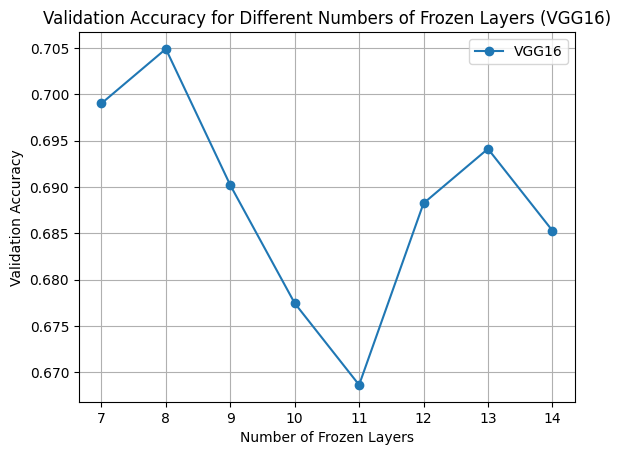

In [51]:
plt.plot(list(vgg16_validation_accuracies.keys()), list(vgg16_validation_accuracies.values()), marker='o', label='VGG16')
# plt.plot(list(resnet_validation_accuracies.keys()), list(resnet_validation_accuracies.values()), marker='o', label='ResNet18')
plt.xlabel('Number of Frozen Layers')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy for Different Numbers of Frozen Layers (VGG16)')
plt.grid(True)
plt.show()

VGG16 with ImageNet pre-trained weights
- relatively simply architecture with a series of convolutional layers followed by fully connected layers => easy to fine tune
- use of pretrained weights bcos the model has been pretrained to learn from ImageNet 

Why freeze initial layers
- initial layers learn basic low level features like edges, textures and basic patterns
- freezing = cannot update when training
- so general features are preserved while deeper layers are allowed to adapt to specifics of flower dataset

Why modify the last layer:
- replace with new linear layer with 102 output units (no of classes)
- initial model has 1000 output units so its necessary to replace
- linear layer allows for softmax activation
    - linear layer outputs logits that correspond to each class
    - softmax function transform logits into probabilities by applying exponential function to each logit and then normalizing them so they sum to 1
     [Softmax Pytorch Link](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)

optimizer: SGD
- learnt in course
- use batch size of 32 as smaller class is 40, larger class is 258, have to balance between the 2
- momentum is used to accelerate optimization process by consideirng past gradients to smoothen updates => faster convergence and lower oscillation in gradients
- weight decay: prevent overfitting
- SGD offers better generalization

lr scheduler
- reduce learning rate during training helps model to converge to minimum and allow for smaller and more precise adjustments in later epoch



In [53]:
# save model with 8 frozen layers

model = load_vgg16(8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)

model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30, patience=5)

torch.save(model.state_dict(), 'model_vgg16(8).pth')


c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 4.6664 Acc: 0.0125
valid Loss: 4.5064 Acc: 0.0451

Epoch 1/29
----------
train Loss: 4.4897 Acc: 0.0463
valid Loss: 4.1606 Acc: 0.1127

Epoch 2/29
----------
train Loss: 4.1126 Acc: 0.1023
valid Loss: 3.3488 Acc: 0.2363

Epoch 3/29
----------
train Loss: 3.5063 Acc: 0.2201
valid Loss: 2.3872 Acc: 0.4647

Epoch 4/29
----------
train Loss: 3.1699 Acc: 0.2965
valid Loss: 1.9304 Acc: 0.5343

Epoch 5/29
----------
train Loss: 2.8867 Acc: 0.3882
valid Loss: 1.7667 Acc: 0.6010

Epoch 6/29
----------
train Loss: 2.8177 Acc: 0.3986
valid Loss: 1.5235 Acc: 0.6363

Epoch 7/29
----------
train Loss: 2.4862 Acc: 0.4966
valid Loss: 1.3395 Acc: 0.6667

Epoch 8/29
----------
train Loss: 2.3211 Acc: 0.5336
valid Loss: 1.3109 Acc: 0.6990

Epoch 9/29
----------
train Loss: 2.2871 Acc: 0.5497
valid Loss: 1.3794 Acc: 0.6941

Epoch 10/29
----------
train Loss: 2.0550 Acc: 0.6114
valid Loss: 1.3289 Acc: 0.6961

Epoch 11/29
----------
train Loss: 2.2191 Acc: 0.5729
valid Loss

#### VGG19

In [27]:
def load_vgg19(num_frozen_layers):
    vgg19 = models.vgg19(pretrained=True)
    
    # Freeze layers
    layers_to_freeze = list(vgg19.features.children())[:num_frozen_layers]
    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False
    
    # Modify the final fully connected layer for 102 classes
    num_features = vgg19.classifier[6].in_features
    vgg19.classifier[6] = nn.Linear(num_features, 102)
    return vgg19.to(device)

# Load VGG19 with specified number of frozen layers
validation_accuracies_vgg19 = {}
for num_frozen_layers in range(12,18):

    model = load_vgg19(num_frozen_layers)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)
    
    # Define the learning rate scheduler
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the model
    model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30, patience=5)
    # Get the best validation accuracy for this configuration
    best_valid_acc = max(accuracy_history['valid'])
    validation_accuracies_vgg19[num_frozen_layers] = best_valid_acc

    print(f"Best validation accuracy with {num_frozen_layers} frozen layers: {best_valid_acc:.4f}")






c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 4.6672 Acc: 0.0112
valid Loss: 4.5465 Acc: 0.0588

Epoch 1/29
----------
train Loss: 4.5257 Acc: 0.0322
valid Loss: 4.2618 Acc: 0.1039

Epoch 2/29
----------
train Loss: 4.3289 Acc: 0.0638
valid Loss: 3.6010 Acc: 0.2049

Epoch 3/29
----------
train Loss: 3.8626 Acc: 0.1475
valid Loss: 2.8935 Acc: 0.3304

Epoch 4/29
----------
train Loss: 3.4385 Acc: 0.2391
valid Loss: 2.3204 Acc: 0.4588

Epoch 5/29
----------
train Loss: 2.9481 Acc: 0.3598
valid Loss: 1.9356 Acc: 0.5373

Epoch 6/29
----------
train Loss: 2.7401 Acc: 0.4074
valid Loss: 1.7636 Acc: 0.6000

Epoch 7/29
----------
train Loss: 2.4370 Acc: 0.5058
valid Loss: 1.5072 Acc: 0.6490

Epoch 8/29
----------
train Loss: 2.7853 Acc: 0.4271
valid Loss: 1.5141 Acc: 0.6578

Epoch 9/29
----------
train Loss: 2.5570 Acc: 0.4742
valid Loss: 1.4380 Acc: 0.6716

Epoch 10/29
----------
train Loss: 2.5418 Acc: 0.4893
valid Loss: 1.4579 Acc: 0.6578

Epoch 11/29
----------
train Loss: 2.3481 Acc: 0.5409
valid Loss

C:\Users\alici\AppData\Local\Temp\ipykernel_17324\501189650.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


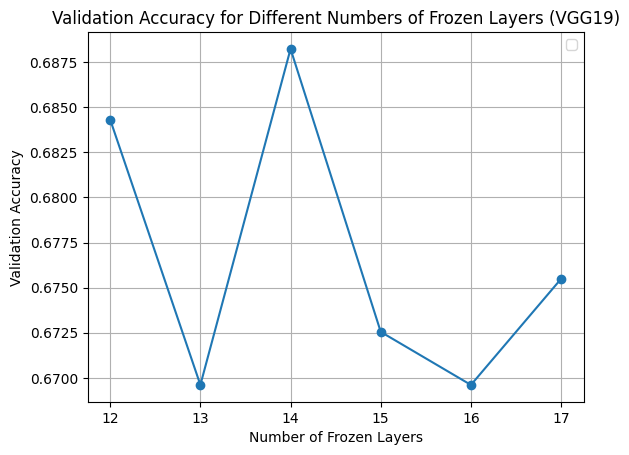

In [28]:
# plot the accuracies
plt.plot(list(validation_accuracies_vgg19.keys()), list(validation_accuracies_vgg19.values()), marker='o')
plt.xlabel('Number of Frozen Layers')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy for Different Numbers of Frozen Layers (VGG19)')
plt.grid(True)
plt.show()

In [29]:
# save model with 14 frozen layers

model = load_vgg19(14)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)

model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30, patience=5)

torch.save(model.state_dict(), 'model_vgg19(14).pth')


c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 4.6822 Acc: 0.0101
valid Loss: 4.5808 Acc: 0.0324

Epoch 1/29
----------
train Loss: 4.5809 Acc: 0.0290
valid Loss: 4.4764 Acc: 0.0578

Epoch 2/29
----------
train Loss: 4.4252 Acc: 0.0490
valid Loss: 3.9509 Acc: 0.1422

Epoch 3/29
----------
train Loss: 4.0213 Acc: 0.1070
valid Loss: 3.4031 Acc: 0.2431

Epoch 4/29
----------
train Loss: 3.7964 Acc: 0.1691
valid Loss: 2.7403 Acc: 0.3902

Epoch 5/29
----------
train Loss: 3.2853 Acc: 0.2666
valid Loss: 2.2450 Acc: 0.4824

Epoch 6/29
----------
train Loss: 3.0439 Acc: 0.3334
valid Loss: 1.9229 Acc: 0.5324

Epoch 7/29
----------
train Loss: 2.8098 Acc: 0.4024
valid Loss: 1.7308 Acc: 0.5794

Epoch 8/29
----------
train Loss: 2.7586 Acc: 0.4317
valid Loss: 1.5720 Acc: 0.6206

Epoch 9/29
----------
train Loss: 2.6509 Acc: 0.4566
valid Loss: 1.4563 Acc: 0.6598

Epoch 10/29
----------
train Loss: 2.6358 Acc: 0.4522
valid Loss: 1.4535 Acc: 0.6853

Epoch 11/29
----------
train Loss: 2.4748 Acc: 0.5145
valid Loss

### Transformer

In [57]:
import time
import copy
import torch

def train_model_vit(model, criterion, optimizer, scheduler, num_epochs, patience):
    start = time.time()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, delta=0)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    accuracy_history = {'train': [], 'valid': []}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Apply mixup only in the training phase
                if phase == 'train':
                    inputs, labels_a, labels_b, lam = mixup(inputs, labels, alpha=1.0)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    # Extract logits from outputs
                    logits = outputs.logits

                    # Get predictions from logits
                    _, preds = torch.max(logits, 1)

                    # Calculate loss with mixup in training phase
                    if phase == 'train':
                        loss = lam * criterion(logits, labels_a) + (1 - lam) * criterion(logits, labels_b)
                    else:
                        loss = criterion(logits, labels)  # Normal loss in validation

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update running loss
                running_loss += loss.item() * inputs.size(0)

                # Calculate correct predictions for mixup in training phase
                if phase == 'train':
                    running_corrects += lam * (preds == labels_a).sum().item() + (1 - lam) * (preds == labels_b).sum().item()
                else:
                    running_corrects += (preds == labels).sum().item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            accuracy_history[phase].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Early stopping check in the validation phase
            if phase == 'valid':
                early_stopping(epoch_loss, model)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    model.load_state_dict(early_stopping.get_best_model_weights())
                    return model, accuracy_history

        print()

    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, accuracy_history


In [ ]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from transformers import ViTForImageClassification

def load_vit(num_frozen_layers):
    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224',
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    
    # Access the transformer encoder layers
    encoder_layers = list(model.vit.encoder.layer)
    
    # Freeze the specified number of layers
    layers_to_freeze = encoder_layers[:num_frozen_layers]
    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False

    return model.to(device)

# Loop through different configurations of frozen layers
for num_frozen_layers in range(8, 11):
    model = load_vit(num_frozen_layers)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, weight_decay=0.01)

    # Define the learning rate scheduler
    exp_lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the model
    model, accuracy_history = train_model_vit(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30, patience=5)

    # Get the best validation accuracy for this configuration
    best_valid_acc = max(accuracy_history['valid'])

    print(f"Best validation accuracy with {num_frozen_layers} frozen layers: {best_valid_acc:.4f}")


### EfficientNet - B0

- known for high accuracy with small parameters, and less computational cost
- suitable for smaller datasets
- generally performs better with data augemtation 
    - data augmentation necessary as each class only has limited number of samples

### ResNet50

- established model and captures various levels of features, good when differentaiting 77 classes
- residual connections -> easier to fine tune without overfitting
- more computationally intensive but not too bad